# Basics of q learning

In [65]:
import numpy as np 
import matplotlib.pyplot as plt

## Classes and Functions

### Creating grids

In [9]:
ACTION_SPACE = ('U','D','L','R')

In [37]:
class Grid: # Environment
    def __init__(self,rows,cols,start):
        self.rows = rows
        self.cols = cols
        self.i = start[0]
        self.j = start[1]
    
    def set(self, rewards, actions):
        # rewards should be a dict of: (i,j):r   (row,coll):reward
        # actioms should be a dict of: (i,j):a   (row,coll):action
        self.rewards = rewards
        self.actions = actions
    
    def set_state(self,s):
        self.i = s[0]
        self.j = s[1]
    
    def current_state(self):
        return (self.i,self.j)
    
    def is_terminal(self,s):
        return s not in self.actions
    
    def get_next_state(self,s,a):
        i,j = s[0], s[1]
        if a in self.actions[(i,j)]:
            if a == 'U':
                i -= 1
            elif a == 'D':
                i += 1
            elif a == 'R':
                j += 1
            elif a == 'L':
                j -=1
        return i,j
    
    def move(self,action):
        self.i,self.j  = self.get_next_state((self.i,self.j),action)
        return self.rewards.get((self.i,self.j),0)
    
    
    def game_over(self):
        # returns true if game is over, else false
        # true is we aare in a state whe no actions are possible
        return (self.i,self.j) not in self.actions
    
    def all_states(self):
        return set(self.actions.keys())|set(self.rewards.keys())
    

In [38]:
def standard_grid():
    # define a  grid that describes the reward for arriving at each state
    # and possibe actions at each state
    # the grid looks like this 
    # x means you can't go there
    # s means start position
    # number means reward at the state
    # . . .  1
    # . x . -1
    # s . .  . 
    g = Grid(3,4,(2,0))
    rewards = {(0,3):1,(1,3):-1}
    actions = {
        (0,0):('D','R'),
        (0,1):('R','L'),
        (0,2):('D','R','L'),
#         (0,3):('D','U','R','L') Terminal state +1
        (1,0):('D','U'),
#         (1,1):('D','U','R','L'), Wall
        (1,2):('D','U','R'),
#         (0,0):('D','U','R','L') Terminal state -1
        (2,0):('U','R'),
        (2,1):('R','L'),
        (2,2):('U','R','L'),
        (2,3):('U','L')
    }
    g.set(rewards,actions)
    return g 


In [39]:
def negative_grid(step_cost = -0.1):
    # in this version we try to minimize the number of moves
    # so we will penalize every move
    g = standard_grid()
    g.rewards.update({
        (0, 0): step_cost,
        (0, 1): step_cost,
        (0, 2): step_cost,
        (1, 0): step_cost,
        (1, 2): step_cost,
        (2, 0): step_cost,
        (2, 1): step_cost,
        (2, 2): step_cost,
        (2, 3): step_cost,
    })
    return g

In [40]:
class WindyGrid(Grid):
    def __init__(self,rows,cols,start):
        self.rows = rows
        self.cols = cols
        self.i = start[0]
        self.j = start[1]
    
    
    def set(self,rewards,actions,probs):
        # rewards should be a dict of: (i,j): r
        # actions should be a dict of: (i,j): A   A is list of action
        self.rewards = rewards 
        self.actions = actions
        self.probs = probs
        
    
    def move(self,action):
        s = (self.i,self.j)
        a = action
        next_state_probs = self.probs[(s,a)]
        next_states = list(next_state_probs.keys())
        s = np.random.choice(next_states,p  = next_probs)
        
        # update the current state
        self.i,self.j = s2

In [41]:
def windy_grid():
    g = WindyGrid(3, 4, (2, 0))
    rewards = {(0, 3): 1, (1, 3): -1}
    actions = {
    (0, 0): ('D', 'R'),
    (0, 1): ('L', 'R'),
    (0, 2): ('L', 'D', 'R'),
    (1, 0): ('U', 'D'),
    (1, 2): ('U', 'D', 'R'),
    (2, 0): ('U', 'R'),
    (2, 1): ('L', 'R'),
    (2, 2): ('L', 'R', 'U'),
    (2, 3): ('L', 'U'),
    }

    # p(s' | s, a) represented as:
    # KEY: (s, a) --> VALUE: {s': p(s' | s, a)}
    probs = {
    ((2, 0), 'U'): {(1, 0): 1.0},
    ((2, 0), 'D'): {(2, 0): 1.0},
    ((2, 0), 'L'): {(2, 0): 1.0},
    ((2, 0), 'R'): {(2, 1): 1.0},
    ((1, 0), 'U'): {(0, 0): 1.0},
    ((1, 0), 'D'): {(2, 0): 1.0},
    ((1, 0), 'L'): {(1, 0): 1.0},
    ((1, 0), 'R'): {(1, 0): 1.0},
    ((0, 0), 'U'): {(0, 0): 1.0},
    ((0, 0), 'D'): {(1, 0): 1.0},
    ((0, 0), 'L'): {(0, 0): 1.0},
    ((0, 0), 'R'): {(0, 1): 1.0},
    ((0, 1), 'U'): {(0, 1): 1.0},
    ((0, 1), 'D'): {(0, 1): 1.0},
    ((0, 1), 'L'): {(0, 0): 1.0},
    ((0, 1), 'R'): {(0, 2): 1.0},
    ((0, 2), 'U'): {(0, 2): 1.0},
    ((0, 2), 'D'): {(1, 2): 1.0},
    ((0, 2), 'L'): {(0, 1): 1.0},
    ((0, 2), 'R'): {(0, 3): 1.0},
    ((2, 1), 'U'): {(2, 1): 1.0},
    ((2, 1), 'D'): {(2, 1): 1.0},
    ((2, 1), 'L'): {(2, 0): 1.0},
    ((2, 1), 'R'): {(2, 2): 1.0},
    ((2, 2), 'U'): {(1, 2): 1.0},
    ((2, 2), 'D'): {(2, 2): 1.0},
    ((2, 2), 'L'): {(2, 1): 1.0},
    ((2, 2), 'R'): {(2, 3): 1.0},
    ((2, 3), 'U'): {(1, 3): 1.0},
    ((2, 3), 'D'): {(2, 3): 1.0},
    ((2, 3), 'L'): {(2, 2): 1.0},
    ((2, 3), 'R'): {(2, 3): 1.0},
    ((1, 2), 'U'): {(0, 2): 0.5, (1, 3): 0.5},
    ((1, 2), 'D'): {(2, 2): 1.0},
    ((1, 2), 'L'): {(1, 2): 1.0},
    ((1, 2), 'R'): {(1, 3): 1.0},
    }
    g.set(rewards, actions, probs)
    return g

### Print vlaues and policies

In [42]:
def print_values(V, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            v = V.get((i,j), 0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="") # -ve sign takes up an extra space
        print("")

In [43]:
def print_policy(P, g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.cols):
            a = P.get((i,j), ' ')
            print("  %s  |" % a, end="")
        print("")

### Max dict and random action

In [44]:
def max_dict(d):
    # returns the argmax (key) and max (value) from a dictionary
    # put this into a function since we are using it so often
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

In [54]:
def random_action(a, eps=0.1):
    # we'll use epsilon-soft to ensure all states are visited
    
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ACTION_SPACE)

# Q Learning

In [87]:
GAMMA = 0.9 # Discount Factor
ALPHA = 0.1 # Learning Rate
ACTION_SPACE = ('U','D','L','R')

In [56]:
grid = negative_grid(step_cost = -0.1)

Rewards:

In [57]:
print_values(grid.rewards,grid)

---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


#### Initialize Q(s,a)

In [79]:
Q = {}
states = grid.all_states()
for s in states:
    Q[s] = {}
    for a in ACTION_SPACE:
        Q[s][a] = 0

In [80]:
Q

{(0, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (1, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (1, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (0, 3): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (0, 1): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (1, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 0): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (2, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0},
 (0, 2): {'U': 0, 'D': 0, 'L': 0, 'R': 0}}

In [81]:
# Keeping track of how many times  Q(s,a) has been updated
update_counts = {}
update_counts_sa = {}
for s in states:
    update_counts_sa[s] = {}
    for a in ACTION_SPACE:
        update_counts_sa[s][a] = 1
        

#### Main loop

In [82]:
# repeat until convergence
t = 1.0
deltas = []

N = 10000
 
for it in range(N):
    if it % 100 == 0:
        t += 1e-2
    if it % 2000 == 0:
        print('it:',it)
    
    # instead of generating an episode, we will PLAY 
    # an episode within this loop
    s = (2,0) # start state
    grid.set_state(s)
    
    # the first (s,r) tuple is the state we start in and 0 
    # (since we don't get a reward) for simply starting the game
    # tge last (s,r) tuple is the terminal state and the final reward
    # the value for the terminal state is by definition 0, so we don't 
    # care about updating it.
    
    a,_ = max_dict(Q[s])
    biggest_change = 0
    while not grid.game_over(): # While not game_over take an action...
        a = random_action(a, eps = 0.5/t) # epsilon-greedy aproach
        # random action also works, but it is slower since it can bump into walls
        # a = np.random.choice(ACTION_SPACE)
        r = grid.move(a)
        s2 = grid.current_state()
        
        # we will update Q(s,a) AS we experience the episode
        old_qsa = Q[s][a]
        # the difference between SARSA and q-learning is with q-learning
        # we will use the max[a']{Q(s',a')} in our update
        # even if we do not end up taking this action in the next step
        a2, max_q_s2a2 = max_dict(Q[s2])
        
        
        # actual q-learning step
        Q[s][a] = Q[s][a]+ALPHA*(r + GAMMA * max_q_s2a2 - Q[s][a])
        
        biggest_change = max(biggest_change,np.abs(old_qsa-Q[s][a]))
    
        # we would like to know how often Q(s) has been updated too
        update_counts[s] = update_counts.get(s,0)+1
        
        # next states become current state
        s = s2
        a = a2
    
    deltas.append(biggest_change)

it: 0
it: 2000
it: 4000
it: 6000
it: 8000


#### Plotting the changes in q

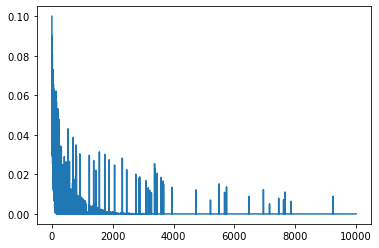

In [83]:
plt.plot(deltas)
plt.show()

#### Determine the policy p* from Q*

In [84]:
# find V* from Q*
policy = {}
V = {}
for s in grid.actions.keys():
    a, max_q = max_dict(Q[s])
    policy[s] = a
    V[s] = max_q

 #### what's the proportion of time we spend updating each part of Q?

In [85]:
print("update counts:")
total = np.sum(list(update_counts.values()))
for k, v in update_counts.items():
    update_counts[k] = float(v) / total
print_values(update_counts, grid)

update counts:
---------------------------
 0.18| 0.18| 0.18| 0.00|
---------------------------
 0.19| 0.00| 0.04| 0.00|
---------------------------
 0.19| 0.02| 0.02| 0.00|


### Final Policy and Values

In [86]:
print("values:")
print_values(V, grid)
print("policy:")
print_policy(policy, grid)


values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.80| 0.00|
---------------------------
 0.31| 0.46| 0.62| 0.46|
policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  R  |  U  |  L  |
